In [1]:
import landsat_prep as lp

/home/hbaier/anaconda3/envs/caoe/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
GB_PATH = "./data/MEX/MEX_ADM2_fixedInternalTopology.shp"
ISO = "MEX"
ADM_ID = "MEX-ADM2-1590546715-B7"
IC = "LANDSAT/LT05/C01/T1"

In [4]:
# lp.downloadGB("MEX", "2")
# lp.prep_landsat(GB_PATH, ISO, ADM_ID, "2010", "1", IC)

In [5]:
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import geopandas as gpd
from PIL import Image
import pandas as pd
import numpy as np
import argparse
import shapely#.geometry import Point, LineString
import random
import torch
import os

from rasterio import plot
from rasterio.plot import show

In [136]:
class ImageGraph():

    def __init__(self, adm_id):

        """
        Args:
            - target_id: If loading data for a municiaplity shapefile, should be the 
              unique shapeID of a municipality, otherwise use 'search' to find the central 
              most node in a shapefile (use this when you load in the imagery boxes)
            - gdf: dataframe with geometry and x & y data IF load_data == True
            - degrees: number of degrees away fromt he target municiaplity to contruct the graph
        __init__ variables:
            - degree_dict: dictionary with keys 0...self.degrees with the values being the list of 
              shapeID's that are k degrees from the target
            - neighbors: dictionary with the keys being each of the municiaplites within self.degrees
              from the target and the values being that municiaplites neighbors (that are no further th)
        """

        self.adm_id = adm_id 
        self.target_path = os.path.join("./data/", adm_id)
        self.imagery_dir = os.path.join(self.target_path, "pngs")
        self.zip_path = os.path.join(self.target_path, "imagery")
        self.temp_path = os.path.join(self.target_path, "temp")
        self.shp_path = os.path.join(self.target_path, [i for i in os.listdir(self.target_path) if i.endswith(".shp")][0])
        self.gdf = gpd.read_file(self.shp_path)
        self.degree_dict = {}
        self.target_id = 0
        self.degrees = 100

        self.x = self.__load_imagery()
        self.neighbors = self.__get_spatial_neighbors()
        self.edge_list = self.__make_edge_list()
        self.adj_list = self.__make_adj_list()
        self.adj_matrix = self.__make_adj_matrix()

    def __load_image(self, image_path):
        image_path = os.path.join(self.imagery_dir, image_path)
        to_tens = transforms.ToTensor()
        return to_tens(Image.open(image_path).convert('RGB')).unsqueeze(0)

    def __load_imagery(self):
        images = os.listdir(self.imagery_dir)
        images = torch.cat([self.__load_image(i) for i in list(images)], dim = 0)
        return images

    def __get_spatial_neighbors(self):
        """
        - Returns a dictionary with the keys being the shapeID's of the municipalities in the graph 
          (within self.degrees) and the values being the neighbors of the shapeID key
        - Runs on initialization
        """
        row = self.gdf[self.gdf['shapeID'] == self.target_id].squeeze()
        target_neighbors = self.gdf[~self.gdf.geometry.disjoint(row.geometry)].shapeID.tolist()
        neighbors = target_neighbors

        all_neighbors = {}
        self.degree_dict[0] = [self.target_id]
        self.degree_dict[1] = [i for i in target_neighbors if i != self.target_id]
    
        # Get neighbors
        for i in range(self.degrees):
            new_n = []
            for n in neighbors:
                cur_row = self.gdf[self.gdf['shapeID'] == n].squeeze()
                cur_neighbors = self.gdf[~self.gdf.geometry.disjoint(cur_row.geometry)].shapeID.tolist()
                if n not in all_neighbors.keys():
                    all_neighbors[n] = cur_neighbors
                    new_n.append(n)
            if i != 0:
                self.degree_dict[i + 1] = new_n

            k = [v for k,v in all_neighbors.items()]
            k = list(set([item for sublist in k for item in sublist]))
            k = [i for i in k if i not in all_neighbors.keys()]
            neighbors = k

            if len(neighbors) == 0:
                break

        # Cleanup: remove all ofthe neighbors of neighbors that are more than one degree fromt he target node
        # i.i. remove all of the muiciaplites in the values that are not in the keys
        u_vals = list(set([item for sublist in all_neighbors.values() for item in sublist]))
        remove_vals = [i for i in u_vals if i not in all_neighbors.keys()]
        for k,v in all_neighbors.items():
            to_remove = [j for j in v if j in remove_vals]
            for tr in to_remove:
                all_neighbors[k] = [i for i in all_neighbors[k] if i not in tr]

        return all_neighbors

    def __make_edge_list(self):
        edge_list = []
        for k,v in self.neighbors.items():
            [edge_list.append([k, cur_v]) for cur_v in v]
        return edge_list

    def __make_adj_list(self):
        """
        Returns an adjacency list based on the self.neighbors_recoded dictionary.
        Since every element in the array needs to have the same number of values, but muni's don't all 
        have the same number of neighbors, it fills the remaining elements in each list with the value -99.
        """
        max_n = len(self.neighbors.keys())
        adj_list = np.full((max_n, max_n), -99)
        for i in self.neighbors.values():
            cur_new_vals = np.pad(np.array(i), (0, max_n - len(i)), constant_values = -99)
            try:
                new_values = np.concatenate((new_values, cur_new_vals))
            except Exception as e:
                new_values = cur_new_vals
        return np.reshape(new_values, (max_n, max_n))

    def __make_adj_matrix(self):
        adj_matrix = np.zeros((len(self.gdf), len(self.gdf)))
        for edge in self.edge_list:
            adj_matrix[edge[0]][edge[1]] = 1
        for i in range(len(self.gdf)):
            adj_matrix[i][i] = 1
        return adj_matrix


    def show(self):

        try:
            os.mkdir(self.temp_path)
        except:
            shutil.rmtree(self.temp_path)
        
        for zipfolder in os.listdir(self.zip_path):
            with zipfile.ZipFile(os.path.join(self.zip_path, zipfolder), 'r') as zip_ref:
                zip_ref.extractall(self.temp_path)

        b1s = [i for i in os.listdir(self.temp_path) if i.endswith("B1.tif")]
        b1s = [rio.open(os.path.join(self.temp_path, i)) for i in b1s]

        fig, ax = plt.subplots(figsize = (12, 10))
        for i in b1s:
            show(i, ax = ax, transform = i.transform, cmap = 'gist_earth')
        self.gdf.plot(ax = ax, color = 'black', alpha = 0) ## alpha is the transparency setting
        plt.show()

        shutil.rmtree(self.temp_path)
        

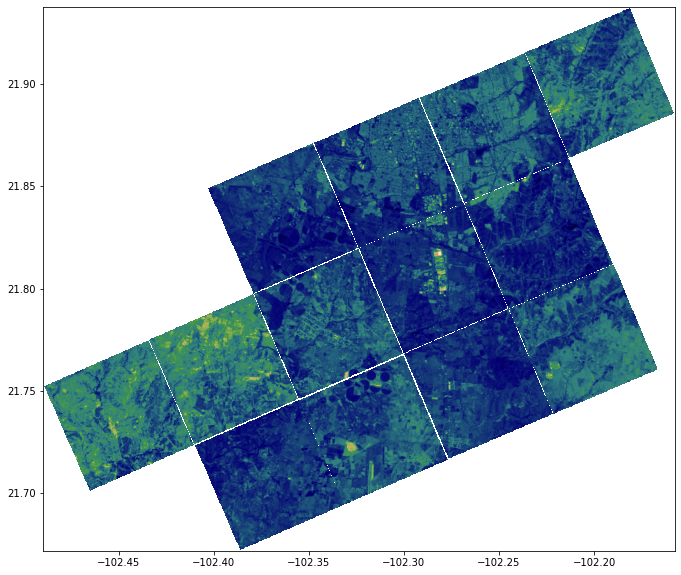

In [134]:
import shutil
import zipfile

ADM_ID = "MEX-ADM2-1590546715-B7"

ImageGraph(adm_id = ADM_ID).show()

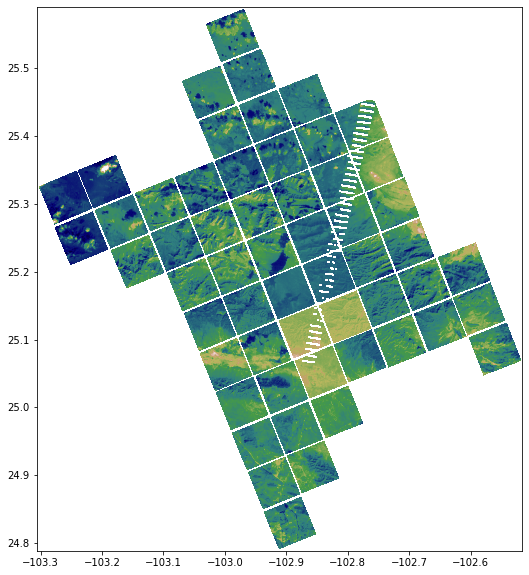

In [138]:
ADM_ID = "MEX-ADM2-1590546715-B48"

# lp.prep_landsat("./data/MEX/MEX_ADM2_fixedInternalTopology.shp", "MEX", ADM_ID, "2010", "1", "LANDSAT/LT05/C01/T1")

ImageGraph(adm_id = ADM_ID).show()

In [96]:
ValueError: 'pinks' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'





SyntaxError: invalid syntax (<ipython-input-96-10fc9fc2b189>, line 1)

In [14]:
from rasterio import plot
from rasterio.plot import show

In [17]:
test1 = rio.open("./data/MEX-ADM2-1590546715-B7/imagery/MEX-ADM2-1590546715-B7_2010_1_box12/MEX-ADM2-1590546715-B7_2010_1_box12.B1.tif").read(1)

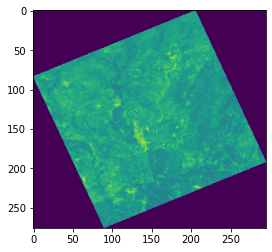

In [18]:
plt.imshow(test1)
# ax = mpl.pyplot.gca()

In [19]:
test1 = test1.astype("float")

test1[test1 == 0] = np.nan

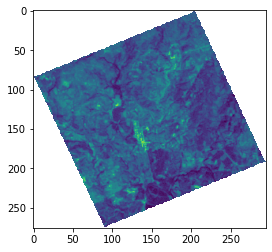

In [20]:
plt.imshow(np.clip(test1, a_min = 0.00001, a_max = None))

# ax = mpl.pyplot.gca()

<AxesSubplot:>

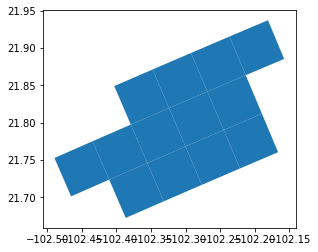

In [22]:
boxes = gpd.read_file("./data/MEX-ADM2-1590546715-B7/MEX-ADM2-1590546715-B7.shp")
boxes.plot()

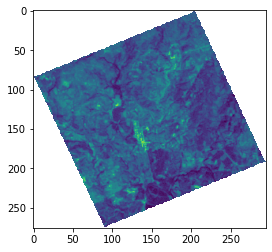

In [23]:
boxes.plot()
plt.imshow(np.clip(test1, a_min = 0.00001, a_max = None))


In [35]:
test1 = rio.open("./data/MEX-ADM2-1590546715-B7/imagery/MEX-ADM2-1590546715-B7_2010_1_box12/MEX-ADM2-1590546715-B7_2010_1_box12.B1.tif")
test2 = rio.open("./data/MEX-ADM2-1590546715-B7/imagery/MEX-ADM2-1590546715-B7_2010_1_box12/MEX-ADM2-1590546715-B7_2010_1_box12.B2.tif")
test3 = rio.open("./data/MEX-ADM2-1590546715-B7/imagery/MEX-ADM2-1590546715-B7_2010_1_box12/MEX-ADM2-1590546715-B7_2010_1_box12.B3.tif")

In [38]:
f1 = "./data/MEX-ADM2-1590546715-B7/imagery/MEX-ADM2-1590546715-B7_2010_1_box12/MEX-ADM2-1590546715-B7_2010_1_box12.B1.tif"
f2 = "./data/MEX-ADM2-1590546715-B7/imagery/MEX-ADM2-1590546715-B7_2010_1_box12/MEX-ADM2-1590546715-B7_2010_1_box12.B2.tif"
f3 = "./data/MEX-ADM2-1590546715-B7/imagery/MEX-ADM2-1590546715-B7_2010_1_box12/MEX-ADM2-1590546715-B7_2010_1_box12.B3.tif"

In [42]:
import rasterio

file_list = [f3, f2, f1]

# Read metadata of first file
with rasterio.open(file_list[0]) as src0:
    meta = src0.meta

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer and write it to stack
with rasterio.open('stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

In [43]:
hm = rio.open("./stack.tif")

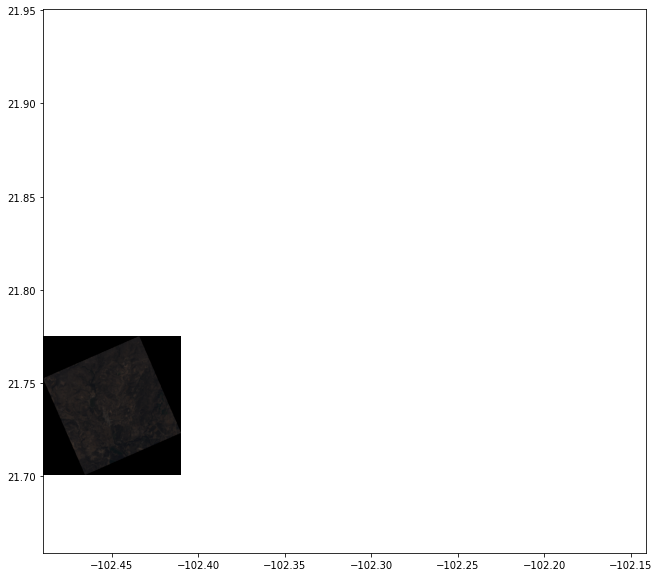

In [54]:
fig, ax = plt.subplots(figsize=(12, 10))
show(hm, ax=ax, transform = hm.transform)
boxes.plot(ax=ax, color='white', alpha=0) ## alpha is the transparency setting
plt.show()

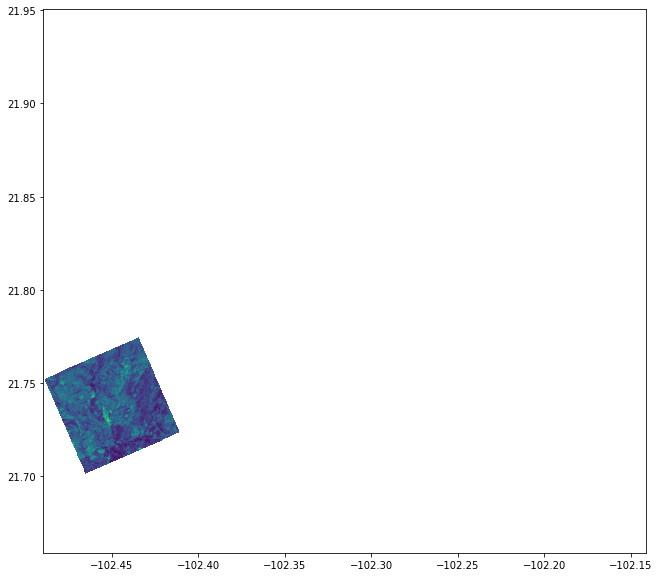

In [53]:
fig, ax = plt.subplots(figsize=(12, 10))
show(test1, ax=ax, transform = test1.transform)
boxes.plot(ax=ax, color='black', alpha=0) ## alpha is the transparency setting
plt.show()

In [56]:
test1 = rio.open("./data/MEX-ADM2-1590546715-B7/imagery/MEX-ADM2-1590546715-B7_2010_1_box12/MEX-ADM2-1590546715-B7_2010_1_box12.B1.tif")
test2 = rio.open("./data/MEX-ADM2-1590546715-B7/imagery/MEX-ADM2-1590546715-B7_2010_1_box11/MEX-ADM2-1590546715-B7_2010_1_box11.B1.tif")


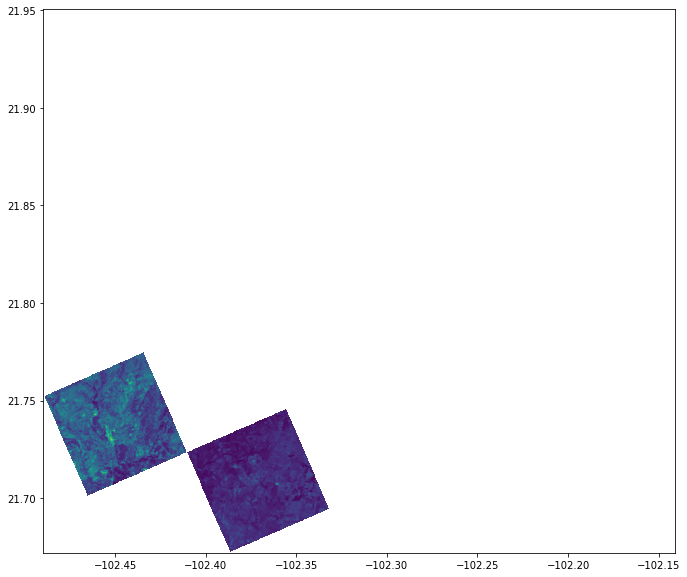

In [59]:
fig, ax = plt.subplots(figsize = (12, 10))
show(test1, ax=ax, transform = test1.transform)
show(test2, ax = ax, transform = test2.transform)
boxes.plot(ax = ax, color = 'black', alpha = 0) ## alpha is the transparency setting
plt.show()

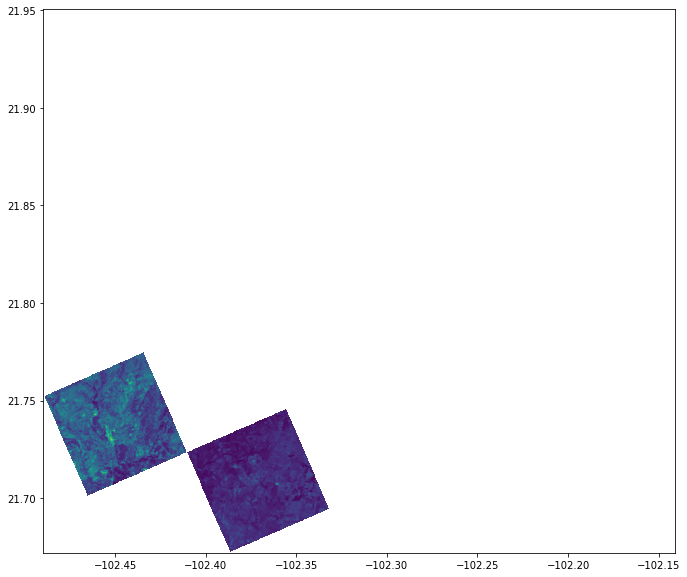

In [62]:
test = [test1, test2]

fig, ax = plt.subplots(figsize = (12, 10))

for i in test:
    show(i, ax=ax, transform = i.transform)
    # show(test2, ax = ax, transform = test2.transform)
boxes.plot(ax = ax, color = 'black', alpha = 0) ## alpha is the transparency setting
plt.show()